## Classification of Stars 
In this exercise we are going to adapt the previously provided code to work on a comparatively small dataset of star measurements from [Kaggle](https://www.kaggle.com/deepu1109/star-dataset). From just four measurements (Temperature, Luminosity, Radius, Absolute magnitude), we will try to predict the star type (Browm Dwarf, Red Dwarf, White Dwarf, Main Sequence, Supergiant, Hypergiant) by using a Feedforward Neural Network architecture that was trained on 200 measurements. By determining hyperparameters we will optimize our model before we will test the generalization of the model to not seen instances.

In [3]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

import torch.nn.functional as F

from torch import nn, tensor, relu, tanh, optim
from torchvision import datasets, transforms
from torchvision.io import read_image
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

In [4]:
# print(torch.cuda.is_available())
# print(torch.version.cuda)

# cuda_id = torch.cuda.current_device()

# print(torch.cuda.current_device())
       
# print({torch.cuda.get_device_name(cuda_id)})

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


### Class Dataset

In [6]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        star_attributes = torch.Tensor(self.data[index])
        star_label = torch.Tensor([self.labels[index]])
        
        return star_attributes, star_label

### Class nNet

In [7]:
class Star_Net(nn.Module):
    def __init__(self):
        super(Star_Net, self).__init__()
        self.fc1 = nn.Linear(4,16)
        self.fc2 = nn.Linear(16,7)
        
        # Convert weight tensor to float
        self.fc1.weight.data = self.fc1.weight.data.float()
        self.fc2.weight.data = self.fc2.weight.data.float()

    def forward(self, x):
        x = F.relu(self.fc1(x.to(self.fc1.weight.dtype)))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

### Rescale

In [8]:
def rescale(x):
    min_vals = np.min(x, axis=0)
    max_vals = np.max(x, axis=0)
    return (x - min_vals) / (max_vals - min_vals)

### Show performance function

In [9]:
def show_perform(epoch, model, train_loader, test_loader):
    # Get predicted labels for training set
    predicted_train_labels = []
    for inputs, _ in train_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_train_labels.extend(predicted.cpu().numpy())

    # Get predicted labels for testing set
    predicted_test_labels = []
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_test_labels.extend(predicted.cpu().numpy())

    # Convert the true labels to numpy arrays
    true_train_labels = np.array(train_loader.dataset.labels)
    true_test_labels = np.array(test_loader.dataset.labels)

    # Compute the confusion matrices
    train_cm = confusion_matrix(true_train_labels, predicted_train_labels)
    test_cm = confusion_matrix(true_test_labels, predicted_test_labels)

    if (train_cm.shape)[0] == 6:
        train_cm = np.concatenate([train_cm, np.zeros((6,1), int)], axis=1)
        train_cm = np.concatenate([train_cm, np.zeros((1,7), int)], axis=0)

    if (test_cm.shape)[0] == 6:
            test_cm = np.concatenate([test_cm, np.zeros((6,1), int)], axis=1)
            test_cm = np.concatenate([test_cm, np.zeros((1,7), int)], axis=0)

    # Visualize the confusion matrices
    plt.figure(figsize=(10, 5))
    plt.title(epoch)
    plt.subplot(1, 2, 1)
    sns.heatmap(train_cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Training Set Confusion Matrix")
    ax = plt.gca()
    ax.set_xticklabels(["A", "B", "F", "G", "M", "K", "O"])
    ax.set_yticklabels(["A", "B", "F", "G", "M", "K", "O"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    plt.subplot(1, 2, 2)
    sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Testing Set Confusion Matrix")
    ax = plt.gca()
    ax.set_xticklabels(["A", "B", "F", "G", "M", "K", "O"])
    ax.set_yticklabels(["A", "B", "F", "G", "M", "K", "O"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    plt.tight_layout()
    plt.show()

### Train and Evaluate functions

In [10]:
def train(model, train_loader, optimizer, loss_function):
    model.train()
    loss_values = []

    for inputs, labels in train_loader:
        inputs = inputs.to(device).float()  # Convert input tensor to float
        labels = labels.squeeze().to(device).long()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_values.append(loss.item())

    return loss_values


def evaluate(model, test_loader, loss_function):
    model.eval()
    loss_test = []
    correct = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.squeeze().long().to(device)
            inputs = inputs.to(device, dtype=torch.float32)

            outputs = model(inputs)

            loss = loss_function(outputs, labels)
            loss_test.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / len(test_loader.dataset)
    return loss_test, accuracy

### Run function

In [11]:
def run(epochs, learning_rate, train_loader, test_loader):

    # Set the device to be used (CPU or GPU if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize the model
    model = Star_Net().to(device)

    # Define the optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()

    # Initialize lists for plotting
    learning_curve_train = []
    learning_curve_test = []

    # Training loop
    for epoch in range(1, epochs + 1):
        loss_train = train(model, train_loader, optimizer, loss_function)
        loss_test, accuracy = evaluate(model, test_loader, loss_function)

        learning_curve_train.append(torch.mean(torch.tensor(loss_train)))
        learning_curve_test.append(torch.mean(torch.tensor(loss_test)))

        print("Epoch: {}\tTrain loss: {:.4f}\tTest loss: {:.4f}\tTest Accuracy: {:.2f}%".format(
            epoch,
            learning_curve_train[-1],
            learning_curve_test[-1],
            accuracy
            ))
        
    show_perform(epoch, model, train_loader, test_loader)

    return learning_curve_train, learning_curve_test

### Process data

In [12]:
df = pd.read_csv("star_data.csv")

x = np.array(
    df[
        [
            "Temperature (K)",
            "Luminosity(L/Lo)",
            "Radius(R/Ro)",
            "Absolute magnitude(Mv)",
        ]
    ]
)

y = np.array(df["Spectral Class"])

# Rescale
xre = rescale(x)

# Shuffle
rows = np.arange(xre.shape[0])
np.random.shuffle(rows)
xsh = xre[rows, :]
ysh = y[rows]
print(xre[0])
print(xsh[0])

# Split
train_set = tensor(xsh[:200, :])
test_set = tensor(xsh[200:, :])
train_y = ysh[:200]
test_y = ysh[200:]

Train_Set = CustomDataset(train_set, train_y)
Test_Set = CustomDataset(test_set, test_y)

# print(np.unique(train_y, return_counts=True))
# print(np.unique(test_y))
# random_indices = np.random.choice(len(Train_Set), 5)
# for i in Test_Set:
#     sample, label = i
#     print("Input:", sample)
#     print("Label:", label)
#     print()

train_loader = torch.utils.data.DataLoader(Train_Set, batch_size=2)
test_loader = torch.utils.data.DataLoader(Test_Set, batch_size=2)

[2.96629095e-02 2.73127546e-09 2.59099275e-05 3.32796311e-01]
[0.28207351 0.5321278  0.01330635 0.33181358]


Epoch: 1	Train loss: 1.8544	Test loss: 1.8937	Test Accuracy: 2.50%
Epoch: 2	Train loss: 1.6500	Test loss: 1.9487	Test Accuracy: 2.50%
Epoch: 3	Train loss: 1.4975	Test loss: 2.0512	Test Accuracy: 2.50%
Epoch: 4	Train loss: 1.4022	Test loss: 2.1492	Test Accuracy: 2.50%
Epoch: 5	Train loss: 1.3369	Test loss: 2.2261	Test Accuracy: 2.50%
Epoch: 6	Train loss: 1.2831	Test loss: 2.2896	Test Accuracy: 2.50%
Epoch: 7	Train loss: 1.2351	Test loss: 2.3494	Test Accuracy: 2.50%
Epoch: 8	Train loss: 1.1915	Test loss: 2.4071	Test Accuracy: 7.50%
Epoch: 9	Train loss: 1.1517	Test loss: 2.4665	Test Accuracy: 7.50%
Epoch: 10	Train loss: 1.1156	Test loss: 2.5269	Test Accuracy: 10.00%


C:\Users\Xeonis7\AppData\Local\Temp\ipykernel_7844\2102932303.py:37: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


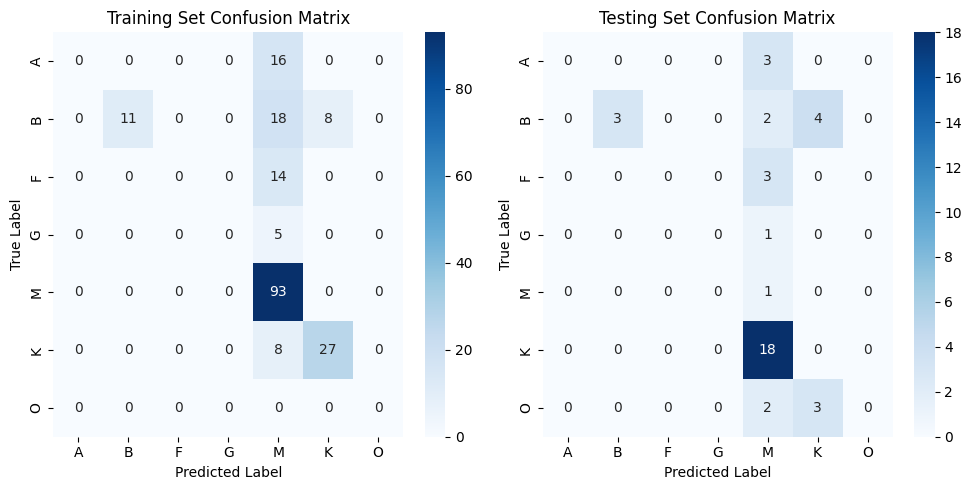

In [13]:
ep = 10
lr = 0.001

learning_curve_train, learning_curve_test = run(ep, lr, train_loader, test_loader)

### Visualize

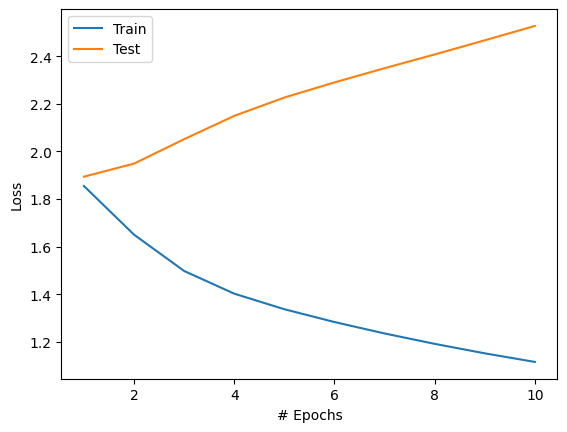

In [14]:
plt.plot(np.arange(1, ep + 1), learning_curve_train, label="Train")
plt.plot(np.arange(1, ep + 1), learning_curve_test, label="Test")
plt.xlabel("# Epochs")
plt.ylabel("Loss")
plt.legend()